In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import warnings
warnings.filterwarnings('ignore')
from time import time
import math
import itertools

In [2]:
import matplotlib
from pylab import rcParams
from matplotlib import pyplot

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.ticker as tkr
%matplotlib inline
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

In [4]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import pmdarima as pm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import grangercausalitytests

In [5]:
df=pd.read_csv(r'C:\Users\GOURAV\Downloads\household_power_consumption.txt', delimiter=';')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [6]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

In [7]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')

In [8]:
df['date_time']=pd.to_datetime(df['date_time'])

In [9]:
df=df.loc[:,['date_time','Global_active_power', 'Global_reactive_power', 'Voltage',	'Global_intensity']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)

In [10]:
df.head()

,date_time,Global_active_power,Global_reactive_power,Voltage,Global_intensity
0,2006-12-16 17:24:00,4.2160,0.4180,234.8400,18.4000
1,2006-12-16 17:25:00,5.3600,0.4360,233.6300,23.0000
2,2006-12-16 17:26:00,5.3740,0.4980,233.2900,23.0000
3,2006-12-16 17:27:00,5.3880,0.5020,233.7400,23.0000
4,2006-12-16 17:28:00,3.6660,0.5280,235.6800,15.8000


In [11]:
df.isnull().sum()

date_time                    0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
dtype: int64

In [12]:
df = df.dropna(subset=['Global_active_power'])
df = df.dropna(subset=['Global_reactive_power'])
df = df.dropna(subset=['Voltage'])
df = df.dropna(subset=['Global_intensity'])

In [13]:
df.isnull().sum()

date_time                0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
dtype: int64

In [14]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (2049280, 5)
The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2010-12-11 23:59:00


In [15]:
df = df.set_index('date_time')
df.index

DatetimeIndex(['2006-12-16 17:24:00', '2006-12-16 17:25:00',
               '2006-12-16 17:26:00', '2006-12-16 17:27:00',
               '2006-12-16 17:28:00', '2006-12-16 17:29:00',
               '2006-12-16 17:30:00', '2006-12-16 17:31:00',
               '2006-12-16 17:32:00', '2006-12-16 17:33:00',
               ...
               '2010-12-11 23:50:00', '2010-12-11 23:51:00',
               '2010-12-11 23:52:00', '2010-12-11 23:53:00',
               '2010-12-11 23:54:00', '2010-12-11 23:55:00',
               '2010-12-11 23:56:00', '2010-12-11 23:57:00',
               '2010-12-11 23:58:00', '2010-12-11 23:59:00'],
              dtype='datetime64[ns]', name='date_time', length=2049280, freq=None)

In [16]:
df= df.resample('D').mean()
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity
date_time,,,,
2006-12-16,3.0535,0.0882,236.2438,13.0828
2006-12-17,2.3545,0.1569,240.0870,9.9990
2006-12-18,1.5304,0.1124,241.2317,6.4217
2006-12-19,1.1571,0.1048,241.9993,4.9264
2006-12-20,1.5457,0.1118,242.3081,6.4674


In [17]:
df.isnull().sum()

Global_active_power      24
Global_reactive_power    24
Voltage                  24
Global_intensity         24
dtype: int64

In [18]:
df = df.dropna(subset=['Global_active_power'])
df = df.dropna(subset=['Global_reactive_power'])
df = df.dropna(subset=['Voltage'])
df = df.dropna(subset=['Global_intensity'])

In [19]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
dtype: int64

In [20]:
mean_df = df.mean()
df_zm = df-mean_df
df_zm.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity
date_time,,,,
2006-12-16,1.9614,-0.0356,-4.5927,8.4531
2006-12-17,1.2624,0.0331,-0.7494,5.3693
2006-12-18,0.4384,-0.0115,0.3953,1.7919
2006-12-19,0.0650,-0.0190,1.1629,0.2967
2006-12-20,0.4536,-0.0120,1.4716,1.8376


In [21]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
dtype: int64

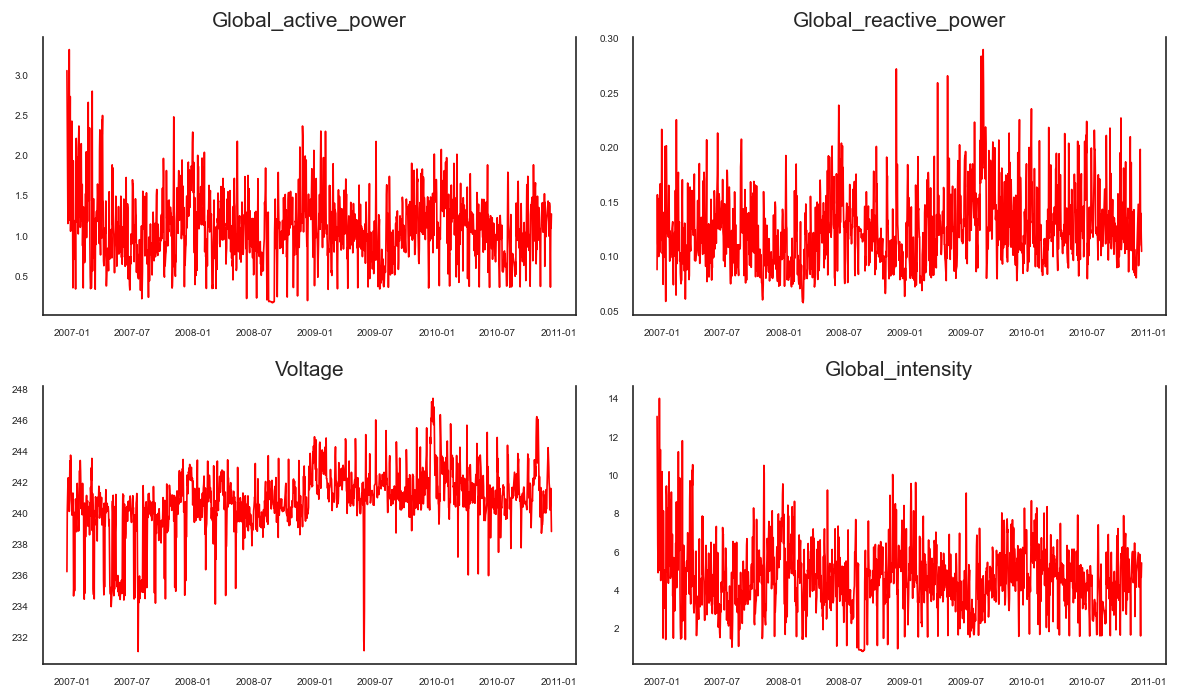

In [22]:
# importing the necessary module
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout();

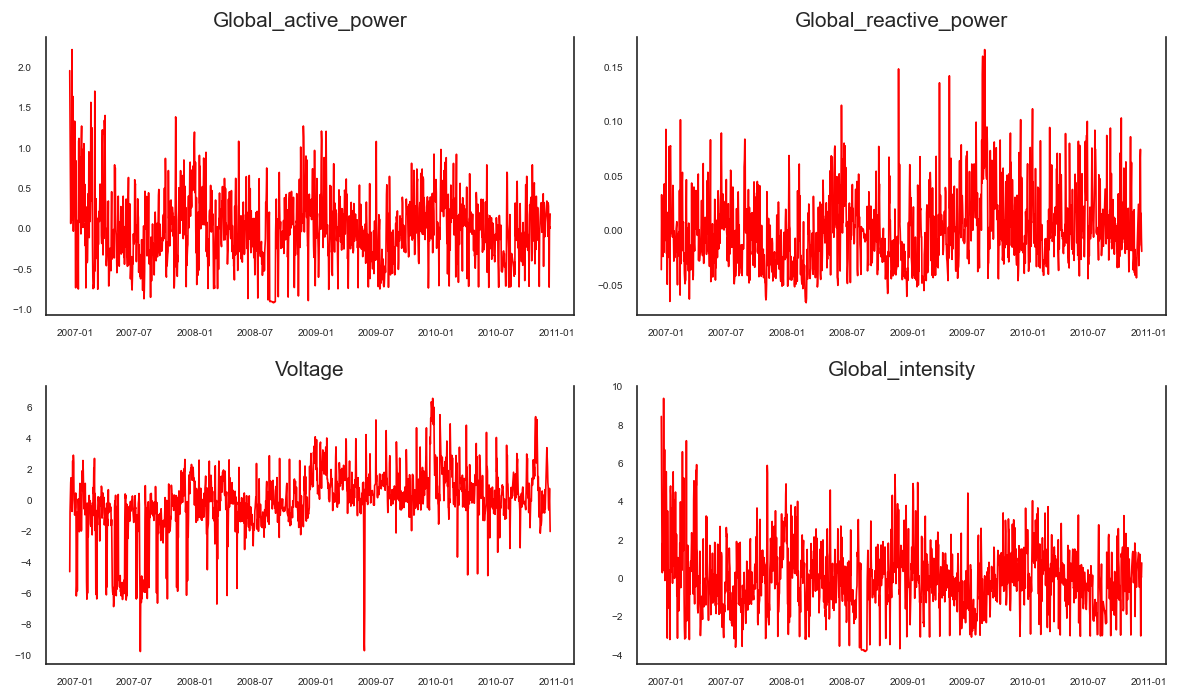

In [23]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_zm[df_zm.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_zm.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout();

In [24]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """ Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag = 'AIC')
    output = {'test_statistics':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length=6): return str(val).ljust(length)
    
    # Print Summary
    print(f'   Augmented Dickey-Fuller Test on "{name}"', "\n  ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance level   = {signif}')
    print(f' Test Statistics      = {output["test_statistics"]}')
    print(f' No. Lags Chosen      = {output["n_lags"]}')
          
    for key, val in r[4].items():
          print(f' Critical value {adjust(key)} = {round(val, 3)}')
          
    if p_value <= signif:
          print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
          print(f" => Series is Stationary.")
          
    else:
          print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
          print(f" => Series in Non-Stationary.")

In [25]:
for name, column in df_zm.iteritems():
          adfuller_test(column, name=column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Global_active_power" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -8.3277
 No. Lags Chosen      = 9
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Global_reactive_power" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -6.7658
 No. Lags Chosen      = 13
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Voltage" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signi

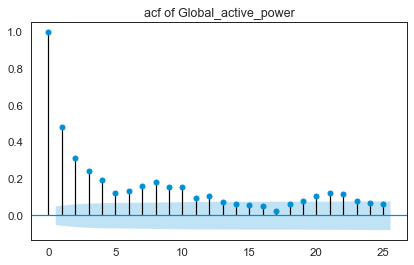

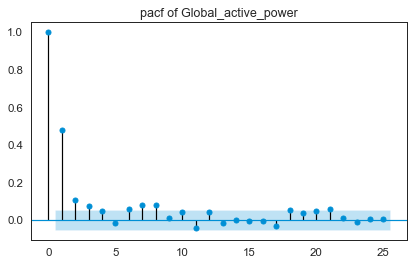

In [26]:
##plot for Global_active_power
plot_acf(df_zm['Global_active_power'], lags=25)
plt.title("acf of Global_active_power")
pyplot.show()

plot_pacf(df_zm['Global_active_power'], lags=25)
plt.title("pacf of Global_active_power")
pyplot.show()

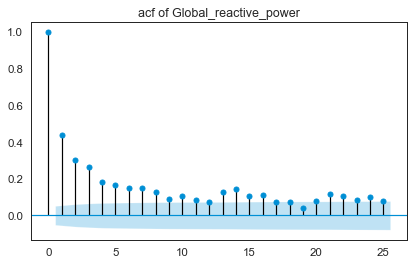

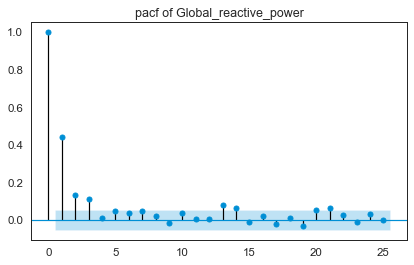

In [27]:
##plot for Global_reactive_power
plot_acf(df_zm['Global_reactive_power'], lags=25)
plt.title("acf of Global_reactive_power")
pyplot.show()

plot_pacf(df_zm['Global_reactive_power'], lags=25)
plt.title("pacf of Global_reactive_power")
pyplot.show()

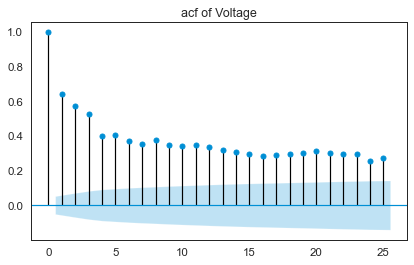

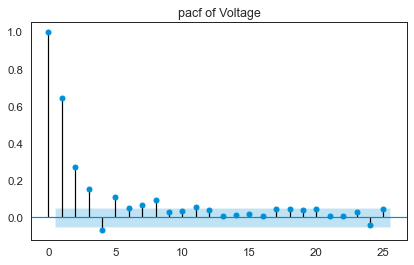

In [28]:
##plot for Voltage
plot_acf(df_zm['Voltage'], lags=25)
plt.title("acf of Voltage")
pyplot.show()

plot_pacf(df_zm['Voltage'], lags=25)
plt.title("pacf of Voltage")
pyplot.show()

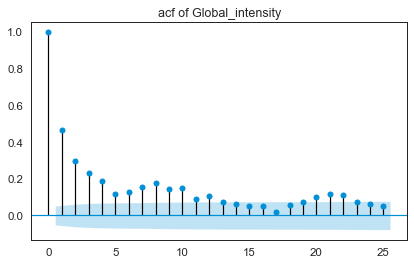

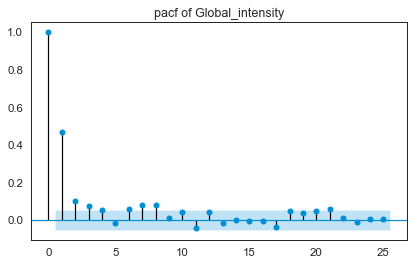

In [29]:
##plot for Global_intensity
plot_acf(df_zm['Global_intensity'], lags=25)
plt.title("acf of Global_intensity")
pyplot.show()

plot_pacf(df_zm['Global_intensity'], lags=25)
plt.title("pacf of Global_intensity")
pyplot.show()

In [30]:
# assigned the integer 15 to the variable 'nobs'
nobs = 15

# assigning the last 15 observations to the variable 'X_test', while the rest will be assigned to the variable 'X_train'
X_train, X_test = df_zm[0:-nobs], df_zm[-nobs:]

#check size
print(X_train.shape)
print(X_test.shape)

(1418, 4)
(15, 4)


In [31]:
# creating a variable named 'maxlag' and assigning the integer 5
maxlag = 5

# assigning the string 'ssr_chi2test' to the variable 'test'
test = 'ssr_chi2test'

# creating a function named 'granger_causation_matrix' with the arguments 'data', 'variables', 'test', and 'verbose'
def granger_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    
    # creating a dataframe with the same dimensions as number of variables entered, assigned to the variable 'X_train'
    X_train = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    # loops through the columns and the indexes
    for c in X_train.columns:
        for r in X_train.index:
            
            # conducts a granger causality test on a variable row and column using the 'maxlag' variable; assigns to 
            # variable test_result
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            
            # locates the test result in the tuple 'test_result' and rounds the number by 4 digits; assigns to 'p_values'
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            
            # if the variable is 'verbose', print the y and x variables and the associated p-value
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            
            # find the smallest p-value and assign to variable 'min_p_value'
            min_p_value = np.min(p_values)
            
            # find the smallest p-value and assign to its respective row and column
            X_train.loc[r, c] = min_p_value
            
    # remane the row and column names based on the relationship
    X_train.columns = [var + '_x' for var in variables]
    X_train.index = [var + '_y' for var in variables]
    return X_train

In [32]:
granger_causation_matrix(X_train, variables = X_train.columns)

,Global_active_power_x,Global_reactive_power_x,Voltage_x,Global_intensity_x
Global_active_power_y,1.0000,0.0000,0.0000,0.0000
Global_reactive_power_y,0.0000,1.0000,0.0000,0.0000
Voltage_y,0.0000,0.0060,1.0000,0.0000
Global_intensity_y,0.0000,0.0000,0.0000,1.0000


In [33]:
def cointegration_test(transfrom_data, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df_zm, -1, 5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length=6):
        return str(val).ljust(length)
    
    # Summary
    print('Name   :: Test Stat > C(95%)       => Signif   \n', '--'*20)
    for col, trace, cvt in zip(df_zm.columns, traces, cvts):
        print(adjust(col), '::', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), '  =>  ', trace >cvt)
        

cointegration_test(X_train)

Name   :: Test Stat > C(95%)       => Signif   
 ----------------------------------------
Global_active_power :: 416.97    > 40.1749    =>   True
Global_reactive_power :: 273.07    > 24.2761    =>   True
Voltage :: 151.82    > 12.3212    =>   True
Global_intensity :: 53.27     > 4.1296     =>   True


In [34]:
mod = VAR(df_zm)
res = mod.fit(maxlags= 15, ic = 'aic')
print(res.summary())

C:\Users\GOURAV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Dec, 2020
Time:                     11:57:03
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -14.6209
Nobs:                     1425.00    HQIC:                  -14.9263
Log likelihood:           2808.72    FPE:                2.74509e-07
AIC:                     -15.1083    Det(Omega_mle):     2.50488e-07
--------------------------------------------------------------------
Results for equation Global_active_power
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           -0.002929         0.008960           -0.327           0.744
L1.Global_active_power          -0.903843         1.001630           -0.902           0.367
L1

In [35]:
pred = res.forecast(df_zm.values, 15)
pred_df = pd.DataFrame(pred, index=df.index[-15:], columns = df.columns)
pred_df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity
date_time,,,,
2010-11-23,0.1169,-0.0078,-0.2699,0.4802
2010-11-24,0.1430,-0.0029,-0.9932,0.6084
2010-11-25,0.0304,0.0023,-0.6088,0.1426
2010-11-26,-0.1233,0.0006,-0.2559,-0.4986
2010-12-01,-0.1826,-0.0043,-0.4641,-0.7518
2010-12-02,-0.0286,0.0011,-0.3883,-0.1087
2010-12-03,0.0030,0.0004,-0.4599,0.0285
2010-12-04,0.0041,-0.0033,-0.4707,0.0280
2010-12-05,0.0324,-0.0015,-0.2921,0.1411


In [36]:
pred_inverse = pred_df.cumsum() 

# inverse the difference values and assigning to variable 'f'
f = pred_inverse + X_test
print(f)

            Global_active_power  Global_reactive_power  Voltage  \
date_time                                                         
2010-11-23               0.1204                -0.0361  -0.5308   
2010-11-24               0.4153                -0.0425  -2.0686   
2010-11-25               0.1921                -0.0516  -1.1721   
2010-11-26               0.2532                -0.0360  -2.6732   
2010-12-01               0.3286                 0.0122   0.8229   
2010-12-02               0.1784                -0.0430  -0.1903   
2010-12-03               0.0095                -0.0312  -1.2629   
2010-12-04              -0.1295                -0.0282  -2.7408   
2010-12-05               0.3167                -0.0282  -3.3227   
2010-12-06               0.2917                 0.0480  -5.0939   
2010-12-07              -0.3037                 0.0565  -5.5636   
2010-12-08              -0.7164                -0.0260  -5.2764   
2010-12-09               0.0056                -0.0050  -4.774

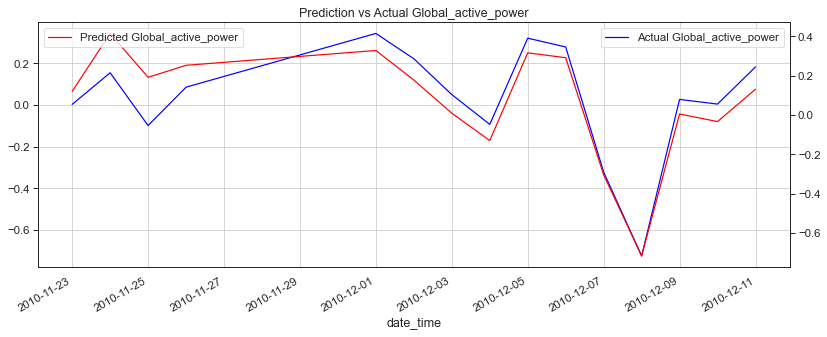

In [37]:
plt.figure(figsize=(12,5))
plt.xlabel('Date')

ax1 = X_test.Global_active_power.plot(color='blue', grid=True, label='Actual Global_active_power')
ax2 = f.Global_active_power.plot(color='red', grid=True, secondary_y=True, label='Predicted Global_active_power')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Prediction vs Actual Global_active_power')
plt.show()

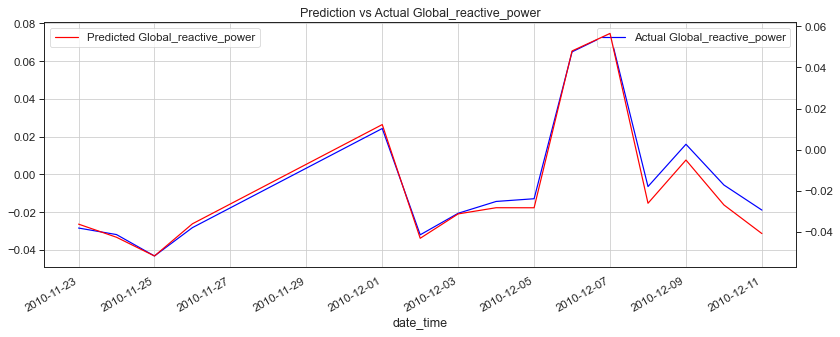

In [38]:
plt.figure(figsize=(12,5))
plt.xlabel('Date')

ax1 = X_test.Global_reactive_power.plot(color='blue', grid=True, label='Actual Global_reactive_power')
ax2 = f.Global_reactive_power.plot(color='red', grid=True, secondary_y=True, label='Predicted Global_reactive_power')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Prediction vs Actual Global_reactive_power')
plt.show()

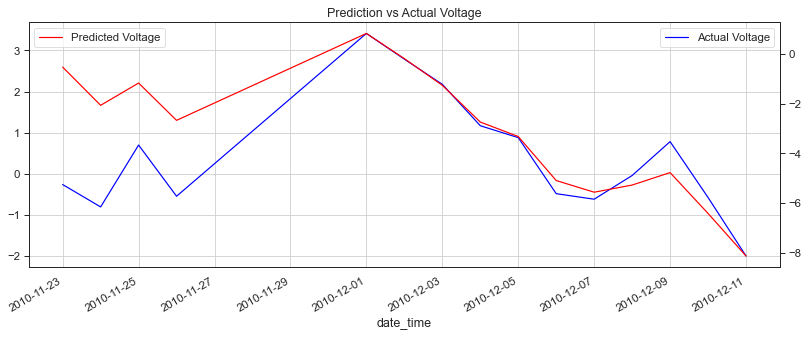

In [39]:
plt.figure(figsize=(12,5))
plt.xlabel('Date')

ax1 = X_test.Voltage.plot(color='blue', grid=True, label='Actual Voltage')
ax2 = f.Voltage.plot(color='red', grid=True, secondary_y=True, label='Predicted Voltage')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Prediction vs Actual Voltage')
plt.show()

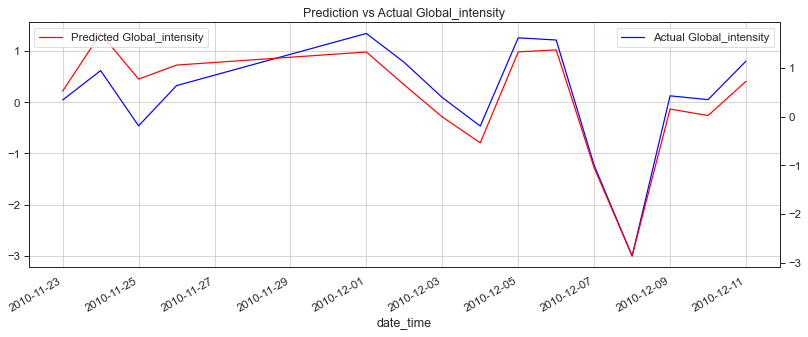

In [40]:
plt.figure(figsize=(12,5))
plt.xlabel('Date')

ax1 = X_test.Global_intensity.plot(color='blue', grid=True, label='Actual Global_intensity')
ax2 = f.Global_intensity.plot(color='red', grid=True, secondary_y=True, label='Predicted Global_intensity')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Prediction vs Actual Global_intensity')
plt.show()

In [41]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

forecast_errors = [X_test.Global_active_power[i]-f.Global_active_power[i] for i in range(len(X_test.Global_active_power))]
bias = sum(forecast_errors) * 1.0/len(X_test.Global_active_power)
print('Bias: %f' % bias)

mae = mean_absolute_error(X_test.Global_active_power, f.Global_active_power)
print('MAE: %f' % mae)

mse = mean_squared_error(X_test.Global_active_power, f.Global_active_power)
print('MSE: %f' % mse)

rmse = sqrt(mse)
print('RMSE: %f' % rmse)

Bias: -0.041204
MAE: 0.075117
MSE: 0.013589
RMSE: 0.116574


In [42]:
forecast_errors = [X_test.Global_reactive_power[i]-f.Global_reactive_power[i] for i in range(len(X_test.Global_reactive_power))]
bias = sum(forecast_errors) * 1.0/len(X_test.Global_reactive_power)
print('Bias: %f' % bias)

mae = mean_absolute_error(X_test.Global_reactive_power, f.Global_reactive_power)
print('MAE: %f' % mae)

mse = mean_squared_error(X_test.Global_reactive_power, f.Global_reactive_power)
print('MSE: %f' % mse)

rmse = sqrt(mse)
print('RMSE: %f' % rmse)

Bias: 0.014438
MAE: 0.014438
MSE: 0.000233
RMSE: 0.015253


In [43]:
forecast_errors = [X_test.Voltage[i]-f.Voltage[i] for i in range(len(X_test.Voltage))]
bias = sum(forecast_errors) * 1.0/len(X_test.Voltage)
print('Bias: %f' % bias)

mae = mean_absolute_error(X_test.Voltage, f.Voltage)
print('MAE: %f' % mae)

mse = mean_squared_error(X_test.Voltage, f.Voltage)
print('MSE: %f' % mse)

rmse = sqrt(mse)
print('RMSE: %f' % rmse)

Bias: 3.665285
MAE: 3.665285
MSE: 16.386988
RMSE: 4.048084


In [44]:
forecast_errors = [X_test.Global_intensity[i]-f.Global_intensity[i] for i in range(len(X_test.Global_intensity))]
bias = sum(forecast_errors) * 1.0/len(X_test.Global_intensity)
print('Bias: %f' % bias)

mae = mean_absolute_error(X_test.Global_intensity, f.Global_intensity)
print('MAE: %f' % mae)

mse = mean_squared_error(X_test.Global_intensity, f.Global_intensity)
print('MSE: %f' % mse)

rmse = sqrt(mse)
print('RMSE: %f' % rmse)

Bias: -0.245848
MAE: 0.302574
MSE: 0.239380
RMSE: 0.489265
